In [22]:
# ignore all warnings
import warnings

warnings.filterwarnings("ignore")

In [23]:
from build_problem import  build_problem, Customer, Route, Vehicule, Link, Node, ChargingStation, Depot
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(100)

# Create the problem
file_path = 'C:/Users/lenovo/Downloads/PFE/projet/Dataset_A/Instances/C101-5.xml'
nodes, links, requests, vehicles = build_problem(file_path)

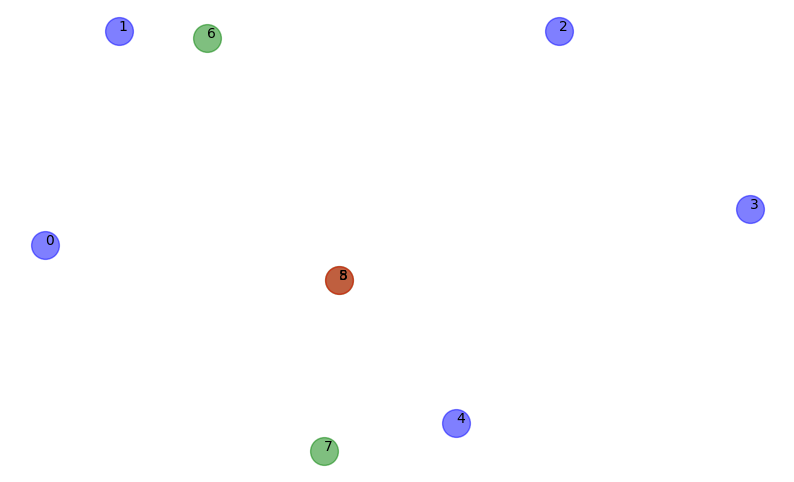

In [24]:
def plot(nodes):
        # plot the customer nodes in blue and depot nodes in red and charging stations in green and line between them in grey
        node_ids = list(nodes.keys())
        for node_id in node_ids:
            node = nodes[node_id]
            if isinstance(node, Customer):
                plt.scatter(node.x, node.y, color='blue', alpha=0.5, s=400)
                plt.text(node.x, node.y, node.node_id)
            elif isinstance(node, Depot):
                plt.scatter(node.x, node.y, color='red', alpha=0.5, s=400)
                plt.text(node.x, node.y, node.node_id)
            elif isinstance(node, ChargingStation):
                plt.scatter(node.x, node.y, color='green', alpha=0.5, s=400)
                plt.text(node.x, node.y, node.node_id)

        # grey background
        
        # no axis
        plt.axis('off')

        # change the background color
        plt.gca().set_facecolor('lightgrey')
        plt.show()



plt.figure(figsize=(10, 6))
plot(nodes)

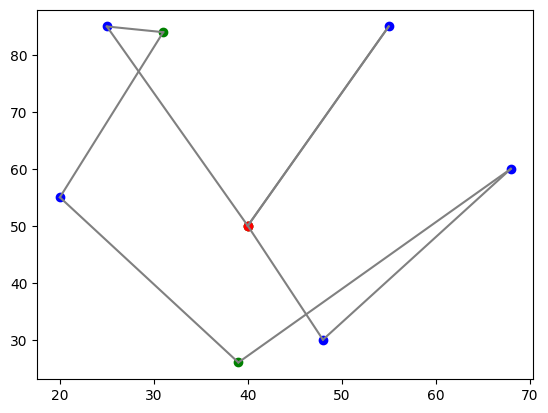

In [25]:
from Generate_random import generate_random_route

# Generate a random route
route = generate_random_route(nodes)
route_obj = Route(1, route)
route_obj.plot(nodes)

In [26]:
route_obj.calculate_energy_consumption(links)

140

In [27]:
def calculate_energy_consumption(route, links):
    route = Route(1, route)
    energy_consumption = route.calculate_energy_consumption(links)
    return energy_consumption


In [28]:
import random

def generate_neighbor(route, nodes):
    new_route = route.copy()
    
    # Randomly decide whether to swap customers or add/remove charging stations
    action = random.choice(['swap_customers', 'modify_charging_stations'])
    
    if action == 'swap_customers':
        # Get a list of customer nodes (ignoring depots and charging stations)
        customer_indices = [i for i in range(1, len(route) - 1) if isinstance(nodes[route[i]], Customer)]
        if len(customer_indices) > 1:
            # Choose two customers to swap
            i, j = random.sample(customer_indices, 2)
            new_route[i], new_route[j] = new_route[j], new_route[i]  # Swap their positions

    elif action == 'modify_charging_stations':
        charging_station_indices = [i for i in range(1, len(route) - 1) if isinstance(nodes[route[i]], ChargingStation)]
        # Randomly decide to add or remove a charging station
        modify_action = random.choice(['add', 'remove'])
        
        if modify_action == 'add':
            # Choose a random charging station from available ones
            available_charging_stations = [node.node_id for node in nodes.values() if isinstance(node, ChargingStation)]
            # Remove charging stations that are already in the route
            available_charging_stations = [cs for cs in available_charging_stations if cs not in new_route]
            if available_charging_stations:
                # Insert a random charging station at a random valid position
                new_station = random.choice(available_charging_stations)
                position = random.randint(1, len(new_route) - 1)
                new_route.insert(position, new_station)

        elif modify_action == 'remove' and charging_station_indices:
            # Remove a random charging station from the route
            remove_index = random.choice(charging_station_indices)
            new_route.pop(remove_index)
    
    return new_route


In [29]:
import math

def simulated_annealing(nodes, initial_route, initial_temp, cooling_rate, stopping_temp, links, vehicles, requests):
    current_route = initial_route
    current_energy = calculate_energy_consumption(current_route, links)
    best_route = current_route
    best_energy = current_energy
    temp = initial_temp

    while temp > stopping_temp:
        # Generate a neighboring solution with charging stations and customer swaps
        new_route = generate_neighbor(current_route, nodes)
        Route_obj = Route(1, new_route)
        new_route = generate_neighbor(current_route, nodes)
        new_energy = calculate_energy_consumption(new_route, links)

        # Calculate the acceptance probability
        if new_energy < current_energy:
            current_route = new_route
            current_energy = new_energy
        else:
            # Acceptance probability formula (accept worse solutions with a probability)
            acceptance_probability = math.exp((current_energy - new_energy) / temp)
            if random.random() < acceptance_probability:
                current_route = new_route
                current_energy = new_energy

        # Update the best solution found so far
        if current_energy < best_energy:
            best_route = current_route
            best_energy = current_energy


        # Cool down the temperature
        temp *= cooling_rate

    return best_route, best_energy


In [30]:
# Set the initial temperature, cooling rate, and stopping temperature
initial_temp = 1000
cooling_rate = 0.99
stopping_temp = 0.1

# Run the simulated annealing algorithm
best_route, best_energy = simulated_annealing(nodes, route, initial_temp, cooling_rate, stopping_temp, links, vehicles, requests)

# Plot the best route found
route_obj = Route(1, best_route)
route_obj.plot(nodes)

# Print the energy consumption of the best route
print(f'Best energy consumption: {best_energy:.2f} kWh')



UnboundLocalError: cannot access local variable 'new_energy' where it is not associated with a value